# Unit 3 final project
## Arutyunyan Vitaly (DST-11 Group-23)


# import

In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Загружаем инструменты для категориальных признаков
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [31]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 56

In [32]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [33]:
#DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
DATA_DIR = ""
df_train = pd.read_csv(DATA_DIR+'main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [35]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [37]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
1034,id_1034,Rome,['Pizza'],4584.0,$,49.0,"[[], []]",/Restaurant_Review-g187791-d9602321-Reviews-Ri...,d9602321,0,0.0
1174,id_1174,Berlin,['German'],3682.0,$$ - $$$,40.0,"[['A final beer before airport.', 'Breakfast f...",/Restaurant_Review-g187323-d1795409-Reviews-Ce...,d1795409,0,0.0
5601,id_5601,London,"['Chinese', 'Asian', 'Fast Food']",14331.0,$,12.0,"[['Pancake rolls rule', 'Quick at tasty luncht...",/Restaurant_Review-g186338-d5816172-Reviews-Mr...,d5816172,0,0.0
14175,id_13254,London,"['British', 'International']",13264.0,$$ - $$$,72.0,"[['Very nice afternoon tea!', 'Afternoon tea']...",/Restaurant_Review-g186338-d739324-Reviews-Mad...,d739324,1,3.5
27345,id_4890,Rome,"['Chinese', 'Asian', 'Fusion', 'Taiwanese']",4891.0,$$ - $$$,7.0,"[[], []]",/Restaurant_Review-g187791-d13281040-Reviews-D...,d13281040,1,5.0


In [38]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

## Очистка и подготовка данных

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [39]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [40]:
#data['Number_of_Reviews_isNAN']

In [41]:
# Далее заполняем пропуски 0, вы можете попробовать заполнением средним или средним по городу и тд...
data['Number of Reviews'].fillna(0, inplace=True)

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [42]:
data.nunique(dropna=False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

### (new) Country code

In [44]:
countries_dict = {
    'London': 'England',
    'Paris': 'France',
    'Madrid': 'Spain',
    'Barcelona': 'Spain',
    'Berlin': 'Germany',
    'Milan': 'Italy',
    'Rome': 'Italy',
    'Prague': 'Czech',
    'Lisbon': 'Portugal',
    'Vienna': 'Austria',
    'Amsterdam': 'Holland',
    'Brussels': 'Belgium',
    'Hamburg': 'Germany',
    'Munich': 'Germany',
    'Lyon': 'France',
    'Stockholm': 'Sweden',
    'Budapest': 'Romania',
    'Warsaw': 'Poland',
    'Dublin': 'Ireland',
    'Copenhagen': 'Denmark',
    'Athens': 'Greece',
    'Edinburgh': 'Scotland',
    'Zurich': 'Switzerland',
    'Oporto': 'Portugal',
    'Geneva': 'Switzerland',
    'Krakow': 'Poland',
    'Oslo': 'Norway',
    'Helsinki': 'Finland',
    'Bratislava': 'Slovakia',
    'Luxembourg': 'Luxembourg',
    'Ljubljana': 'Slovenia'
}
data['Country'] = data['City'].map(countries_dict)

countries_labels = LabelEncoder()
countries_labels.fit(data['Country'])
data['country code'] = countries_labels.transform(data['Country'])

In [45]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,Country,country code
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,France,6
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,Finland,5
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,Scotland,17
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,England,4
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,Slovakia,18


In [22]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [23]:
data.head(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,id_2,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,id_3,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,id_4,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.sample(5)

### Cuisine Style

In [24]:
# Признак имеет 23.18% пропусков
# сохраним эту информацию
data['NaN_Cuisine Style'] = pd.isna(data['Cuisine Style']).astype('float64')

# Можно закполнить пропуски значением 'Empty'
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Empty']")



### Price Range

In [25]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [26]:
# Обработка 'Price Range'
# сохранение информации о пропусках, чтобы не потерять
data['NaN_Price_Range'] = pd.isna(data['Price Range']).astype('float64')

# В признаке очень много пропусков 34.7%
# Заполним эти пропуски значением $$ - $$$
data['Price Range'] = data['Price Range'].fillna('$$ - $$$')

# Признак Price Range можно перевести в числовой вид
price_values_dict = {
    '$': 1,
    '$$ - $$$': 2,
    '$$$$': 3
}
data['Price Range'] = data['Price Range'].map(lambda x: price_values_dict.get(x, x))

In [27]:
data['Price Range'].value_counts()

2    40402
1     7816
3     1782
Name: Price Range, dtype: int64

### Number of Reviews

In [28]:
# В признаке 6.4% пропущенных значений
# сохраним эту информацию
data['NaN_Number of reviews'] = pd.isna(data['Number of Reviews']).astype('float64')



### (new) Country

In [29]:
countries_dict = {
    'London': 'England',
    'Paris': 'France',
    'Madrid': 'Spain',
    'Barcelona': 'Spain',
    'Berlin': 'Germany',
    'Milan': 'Italy',
    'Rome': 'Italy',
    'Prague': 'Czech',
    'Lisbon': 'Portugal',
    'Vienna': 'Austria',
    'Amsterdam': 'Holland',
    'Brussels': 'Belgium',
    'Hamburg': 'Germany',
    'Munich': 'Germany',
    'Lyon': 'France',
    'Stockholm': 'Sweden',
    'Budapest': 'Romania',
    'Warsaw': 'Poland',
    'Dublin': 'Ireland',
    'Copenhagen': 'Denmark',
    'Athens': 'Greece',
    'Edinburgh': 'Scotland',
    'Zurich': 'Switzerland',
    'Oporto': 'Portugal',
    'Geneva': 'Switzerland',
    'Krakow': 'Poland',
    'Oslo': 'Norway',
    'Helsinki': 'Finland',
    'Bratislava': 'Slovakia',
    'Luxembourg': 'Luxembourg',
    'Ljubljana': 'Slovenia'
}
data['Country'] = data['City'].map(countries_dict)

countries_labels = LabelEncoder()
countries_labels.fit(data['Country'])
data['country code'] = countries_labels.transform(data['Country'])

KeyError: 'City'

### (new) Capital city (является ли город столицей)

In [32]:
is_capital = {
    'London': 1,
    'Paris' : 1,
    'Madrid': 1,
    'Barcelona': 0,
    'Berlin': 1,
    'Milan': 0,
    'Rome': 1,
    'Prague': 1,
    'Lisbon': 1,
    'Vienna': 1,
    'Amsterdam': 1,
    'Brussels': 1,
    'Hamburg': 0,
    'Munich': 0,
    'Lyon': 0,
    'Stockholm': 1,
    'Budapest': 1,
    'Warsaw': 1,
    'Dublin': 1,
    'Copenhagen': 1,
    'Athens': 1,
    'Edinburgh': 1,
    'Zurich': 1,
    'Oporto': 0,
    'Geneva': 1,
    'Krakow': 0,
    'Oslo': 1,
    'Helsinki': 1,
    'Bratislava': 1,
    'Luxembourg': 1,
    'Ljubljana': 1
}

data['is capital'] = data['City'].map(is_capital)

### (new) Population of city

In [34]:
population = {
    'London': 8908081,
    'Paris' : 2148327,
    'Madrid': 3223334,
    'Barcelona': 1620343,
    'Berlin': 3769495,
    'Milan': 1378689,
    'Rome': 2870500,
    'Prague': 1324277,
    'Lisbon': 505526,
    'Vienna': 1897491,
    'Amsterdam': 857713,
    'Brussels': 179277,
    'Hamburg': 1899160,
    'Munich': 1471508,
    'Lyon': 513275,
    'Stockholm': 975904,
    'Budapest': 1752286,
    'Warsaw': 1790658,
    'Dublin': 554554,
    'Copenhagen': 794128,
    'Athens': 664046,
    'Edinburgh': 488100,
    'Zurich': 415215,
    'Oporto': 214349,
    'Geneva': 201818,
    'Krakow': 769498,
    'Oslo': 681067,
    'Helsinki': 650058,
    'Bratislava': 437725,
    'Luxembourg': 613894,
    'Ljubljana': 284355
}
data['population of city'] = data['City'].map(population)

### (new) Count restaurants in city

In [41]:
r_count = data.groupby('City')['Restaurant_id'].count().to_dict()
# print(r_count)
data['Count rest in city'] = data['City'].map(r_count)

### (new) Relative ranking

In [42]:
data['ralative ranking'] = data['Ranking'] / data['Count rest in city']

### (new) Population on restaurant

In [65]:
data['population_on_rest'] = data['population of city'] / data['Count rest in city']

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
Ranking                    50000 non-null float64
Price Range                50000 non-null int64
Number of Reviews          50000 non-null float64
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
NaN_Price_Range            50000 non-null float64
is capital                 50000 non-null int64
population of city         50000 non-null int64
Count rest in city         50000 non-null int64
ralative ranking           50000 non-null float64
country code               50000 non-null int64
population_on_rest         50000 non-null float64
dtypes: float64(6), int64(6), uint8(1)
memory usage: 4.6 MB


In [50]:
data.sample(7)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,Number_of_Reviews_isNAN,NaN_Price_Range,is capital,Country,population of city,Count rest in city,ralative ranking,country code
4044,id_4044,Berlin,NaN,5541.0,2,15.0,"[['Love this restaurant.', 'Good!'], ['08/24/2...",/Restaurant_Review-g187323-d8649864-Reviews-Pr...,d8649864,0,0.0,0,0.0,1,Germany,3769495,2705,2.048429,7
45879,id_2709,Munich,NaN,2730.0,2,0.0,"[[], []]",/Restaurant_Review-g187309-d13277444-Reviews-P...,d13277444,1,2.0,1,0.0,0,Germany,1471508,1145,2.384279,7
35790,id_2749,Berlin,NaN,2751.0,2,9.0,"[['A very good and restaurant'], ['01/05/2012']]",/Restaurant_Review-g187323-d1037159-Reviews-Or...,d1037159,1,4.5,0,0.0,1,Germany,3769495,2705,1.017006,7
14364,id_224,Helsinki,"['Nepali', 'Vegetarian Friendly']",225.0,2,13.0,"[['Excellent Nepalese', 'Amazing Nepalese Food...",/Restaurant_Review-g189934-d12063468-Reviews-S...,d12063468,1,5.0,0,0.0,1,Finland,650058,475,0.473684,5
38500,id_1162,Warsaw,"['Polish', 'Cafe', 'European', 'Central Europe...",1164.0,2,45.0,"[['Nice morning coffee', 'Entered from the cas...",/Restaurant_Review-g274856-d2693897-Reviews-Re...,d2693897,1,4.0,0,0.0,1,Poland,1790658,925,1.258378,14
9033,id_9033,London,"['Indian', 'Asian', 'Eastern European']",11667.0,2,39.0,"[['Good tasty food', 'SOME POSITIVES, SOME NEG...",/Restaurant_Review-g186338-d1044226-Reviews-He...,d1044226,0,0.0,0,0.0,1,England,8908081,7193,1.621994,4
39410,id_12851,Paris,['French'],12853.0,2,75.0,[['Not as good as Bofinger (The Big brother a....,/Restaurant_Review-g187147-d11930564-Reviews-L...,d11930564,1,3.0,0,0.0,1,France,2148327,6108,2.104289,6


### --

In [67]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

df_preproc = data
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,NaN_Price_Range,is capital,population of city,Count rest in city,ralative ranking,country code,population_on_rest
19574,2178.0,1,5.0,1,4.5,0,0.0,1,505526,1647,1.322404,15,306.937462
31587,479.0,1,0.0,1,4.0,1,0.0,1,613894,263,1.821293,12,2334.197719
26998,786.0,2,150.0,1,4.5,0,0.0,0,1620343,3395,0.231517,20,477.273343
615,132.0,2,47.0,0,0.0,0,0.0,0,513275,1126,0.117229,6,455.839254
20310,1318.0,2,121.0,1,3.5,0,0.0,1,1897491,1443,0.913375,0,1314.962578
30846,4710.0,1,55.0,1,4.5,0,0.0,1,2148327,6108,0.771120,6,351.723477
43941,8404.0,2,2.0,1,4.0,0,0.0,1,2148327,6108,1.375900,6,351.723477
27077,584.0,2,61.0,1,4.0,0,0.0,1,415215,685,0.852555,22,606.153285
35642,2220.0,2,0.0,1,4.0,1,0.0,1,179277,1314,1.689498,1,136.436073
28753,2075.0,2,35.0,1,3.5,0,0.0,1,857713,1372,1.512391,9,625.155248


In [68]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [69]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [70]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 12), (40000, 12), (40000, 11), (32000, 11), (8000, 11))

In [55]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [71]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [72]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=56, verbose=1,
                      warm_start=False)

In [73]:
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
def rating_round(x, base=0.5):
    return base * round(x/base)

def predict(ds):
    return np.array([rating_round(x) for x in model.predict(ds)])

y_pred = predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [74]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1845


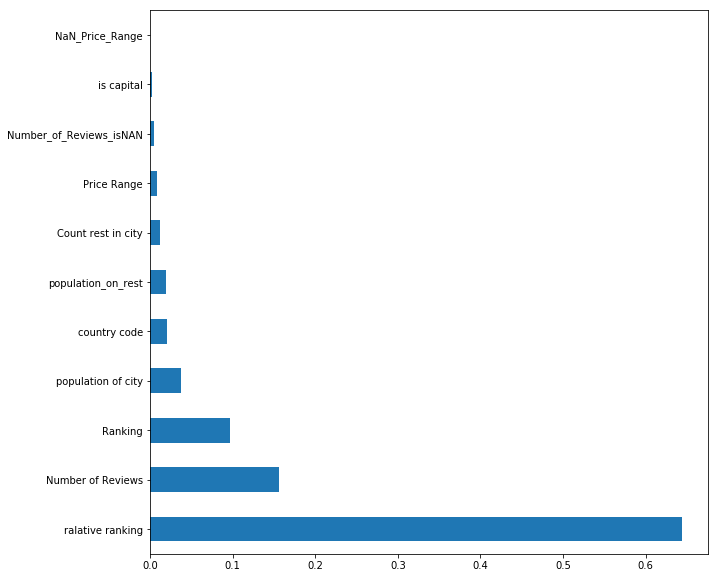

In [75]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

### --

### Посмотрим распределение признака

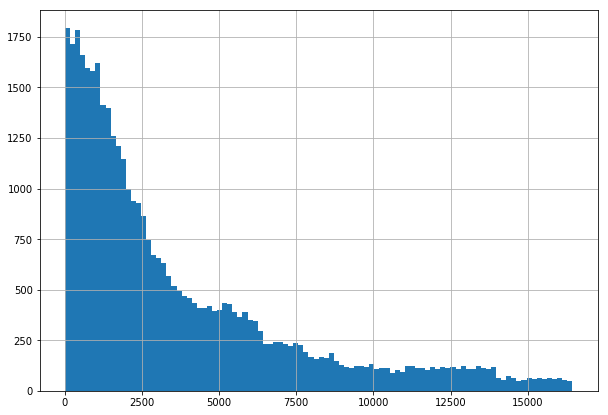

In [23]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

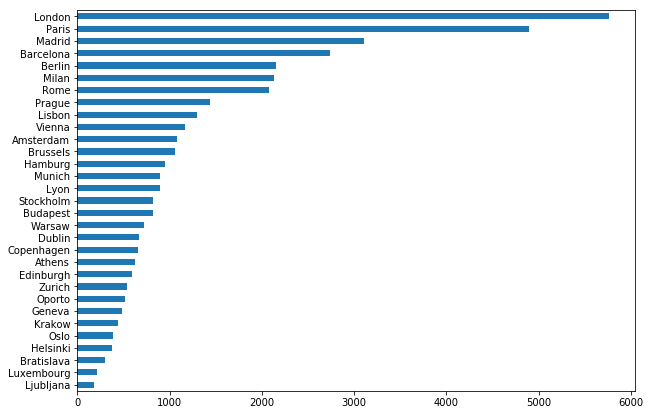

In [24]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

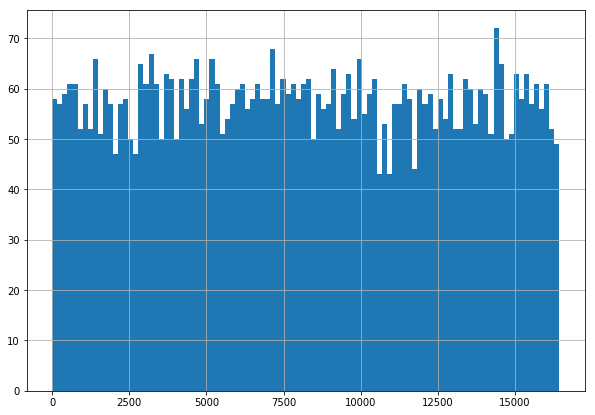

In [25]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

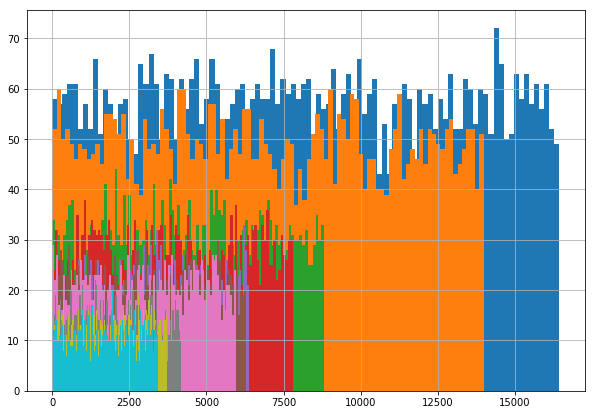

In [26]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

In [29]:
data.groupby(['City'])['Ranking'].mean()

City
Amsterdam     1591.589650
Athens         880.213918
Barcelona     3879.422680
Berlin        3255.417745
Bratislava     462.428947
Brussels      1541.901826
Budapest      1219.061704
Copenhagen     982.147741
Dublin         972.127990
Edinburgh      885.130201
Geneva         713.227119
Hamburg       1375.409781
Helsinki       564.231579
Krakow         616.267148
Lisbon        1867.330298
Ljubljana      234.509009
London        8169.707354
Luxembourg     308.159696
Lyon          1303.902309
Madrid        4388.516391
Milan         3106.027840
Munich        1370.297817
Oporto         752.034268
Oslo           552.569672
Paris         6938.557138
Prague        2086.979626
Rome          2970.733102
Stockholm     1237.482091
Vienna        1711.275814
Warsaw        1055.193514
Zurich         794.280292
Name: Ranking, dtype: float64

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

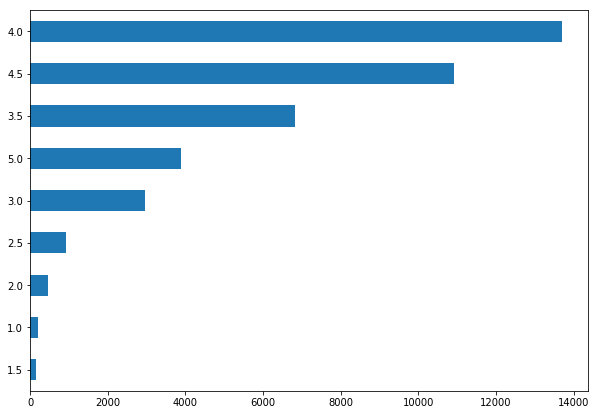

In [30]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

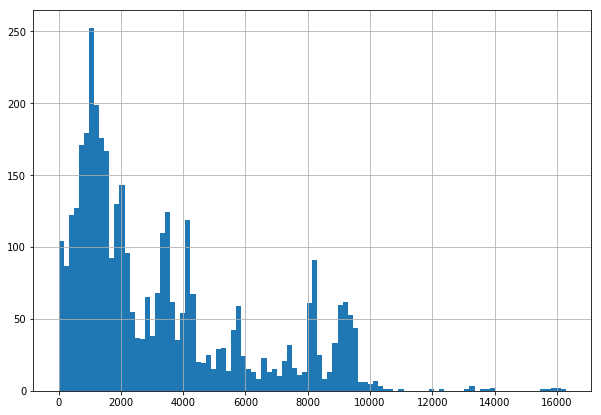

In [31]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

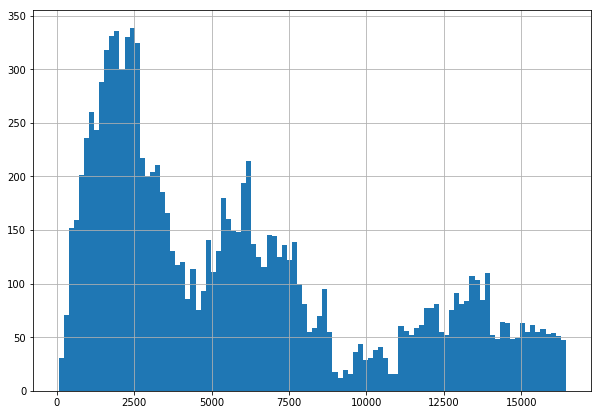

In [32]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

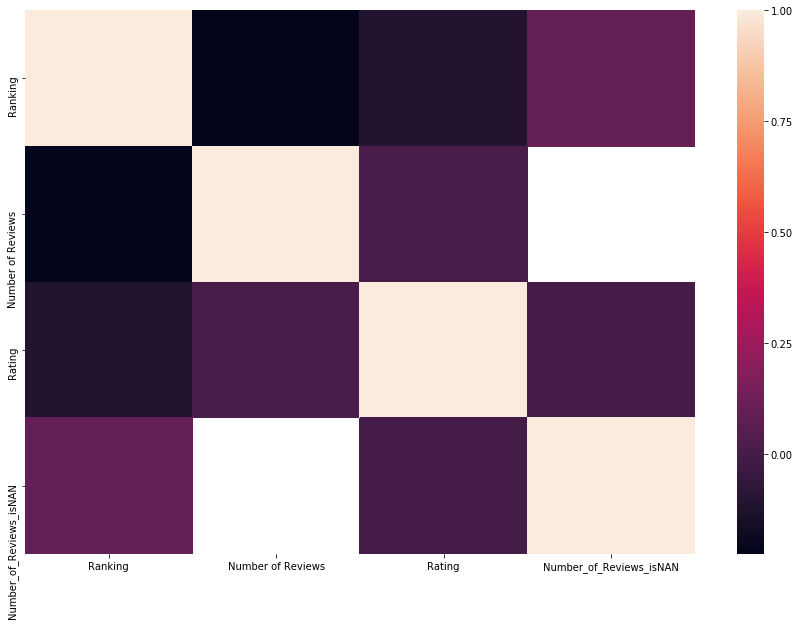

In [33]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [ ]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

In [ ]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [ ]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

In [ ]:
df_preproc.info()

In [5]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

NameError: name 'df_preproc' is not defined

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Model 
Сам ML

In [2]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [3]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

NameError: name 'RANDOM_SEED' is not defined

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['Rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
